# Stocks data ingestion

In [1]:
import mlrun
project = mlrun.get_or_create_project(name='stocks',user_project=True, context="src/")

> 2022-08-10 06:29:30,417 [info] loaded project stocks from MLRun DB


> <b> Steps </b>
>  * [Creating a feature set and declaring the graph](#Creating-a-feature-set-and-declaring-the-graph)
>  * [Dummy ingestion, Deploying ingestion service and getting ingestion endpoint](#Dummy-ingestion,-Deploying-ingestion-service-and-getting-ingestion-endpoint)
>  * [Testing ingestion service](#Testing-ingestion-service)
>  * [Creating scheduled mlrun job to invoke our function every time delta](#Creating-scheduled-mlrun-job-to-invoke-our-function-every-time-delta) 

## Creating a feature set and declaring the graph

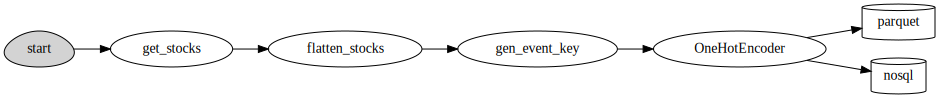

In [2]:
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import DateExtractor, OneHotEncoder
import yahoo_fin.stock_info as si

info_set = fstore.FeatureSet("stocks", 
                             entities=[fstore.Entity("ticker")],
                             timestamp_key='Datetime', 
                             description="stocks feature set")

# how many tickers data we ingest (make sure same number used for ingesting news)
n_tickers = 10


info_set.graph\
        .to(name='get_stocks',handler='get_stocks')\
        .to("storey.steps.Flatten", name="flatten_stocks")\
        .to(name='gen_event_key',handler='gen_event_key',full_event=True)\
        .to(OneHotEncoder(mapping={'ticker2onehot':{ticker:str(idx) for idx,ticker in enumerate(si.tickers_sp500()[:n_tickers])}}))\
    
# Setting default targets (nosql & parquet)
info_set.set_targets(with_defaults=True) 
info_set.plot(rankdir="LR", with_targets=True)

## Dummy ingestion, Deploying ingestion service and getting ingestion endpoint

In [3]:
import os 
import datetime
# code must be present when ingestint locally
from src.stocks import *

# ingesting dummy (A MUST) 
name = os.environ['V3IO_USERNAME']
now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

fstore.ingest(info_set,
              pd.DataFrame.from_dict({'ticker':[name],
                                      'Datetime': now,
                                      'start_delta':59,
                                      'end_delta':31,
                                      'interval':'5m',
                                      'n_stocks':n_tickers}))

Datetime        Open        High         Low  \
ticker                                                                        
A      2022-08-10 06:29:54.778870+00:00  116.669998  116.925003  116.455002   
A      2022-08-10 06:29:54.779536+00:00  116.830002  117.000000  116.519997   
A      2022-08-10 06:29:54.779939+00:00  116.500000  116.949997  116.250000   
A      2022-08-10 06:29:54.780272+00:00  116.709999  117.004997  116.410004   
A      2022-08-10 06:29:54.780594+00:00  116.410004  116.625000  116.209999   
...                                 ...         ...         ...         ...   
ADBE   2022-08-10 06:29:59.419900+00:00  388.519989  389.065002  388.179993   
ADBE   2022-08-10 06:29:59.420253+00:00  388.540009  389.259003  388.429993   
ADBE   2022-08-10 06:29:59.420614+00:00  389.214996  389.850006  389.049988   
ADBE   2022-08-10 06:29:59.420915+00:00  389.029999  389.929993  389.029999   
ADBE   2022-08-10 06:29:59.421230+00:00  389.809998  390.412506  389.230011   

             Close  Volume  ticker2onehot_A  ticker2onehot_AAL  \
ticker                                                           
A       116.925003   63808                1                  0   
A       116.540001   11983                1                  0   
A       116.820000    7225                1                  0   
A       116.519997   12625                1                  0   
A       116.339996    8492                1                  0   
...            ...     ...              ...                ...   
ADBE    388.529999   23041                0                  0   
ADBE    389.209991   28149                0                  0   
ADBE    389.140411   50816                0                  0   
ADBE    389.790985   75805                0                  0   
ADBE    389.440002  144924                0                  0   

        ticker2onehot_AAP  ticker2onehot_AAPL  ticker2onehot_ABBV  \
ticker                                                              
A                       0                   0                   0   
A                       0                   0                   0   
A                       0                   0                   0   
A                       0                   0                   0   
A                       0                   0                   0   
...                   ...                 ...                 ...   
ADBE                    0                   0                   0   
ADBE                    0                   0                   0   
ADBE                    0                   0                   0   
ADBE                    0                   0                   0   
ADBE                    0                   0                   0   

        ticker2onehot_ABC  ticker2onehot_ABMD  ticker2onehot_ABT  \
ticker                                                             
A                       0                   0                  0   
A                       0                   0                  0   
A                       0                   0                  0   
A                       0                   0                  0   
A                       0                   0                  0   
...                   ...                 ...                ...   
ADBE                    0                   0                  0   
ADBE                    0                   0                  0   
ADBE                    0                   0                  0   
ADBE                    0                   0                  0   
ADBE                    0                   0                  0   

        ticker2onehot_ACN  ticker2onehot_ADBE  
ticker                                         
A                       0                   0  
A                       0                   0  
A                       0                   0  
A                       0                   0  
A                       0                   0  
...                   ...

In [4]:
# Define the HTTP Source to_dictable the HTTP trigger on our function and expose the endpoint.
# There is an option to declare key and timestamp inside the http source (here we dont send data through the http hence not needed)
http_source = mlrun.datastore.sources.HttpSource()
info_set.spec.source = http_source

# code_to_function our mlrun wrapped function to deploy the ingestion pipeline on.
# the serving runtimes enables the deployment of our feature set's computational graph
function = mlrun.code_to_function(name='get_stocks',kind='serving',image='mlrun/mlrun', requirements=['yahoo_fin', 'yfinance', 'graphviz'], filename='src/stocks.py')

function.spec.readiness_timeout = 3600

run_config = fstore.RunConfig(function=function, local=False).apply(mlrun.mount_v3io())

In [5]:
# Deploying
info_set_endpoint = fstore.deploy_ingestion_service(featureset=info_set, run_config=run_config)

> 2022-08-10 06:30:00,322 [info] Starting remote function deploy
2022-08-10 06:30:00  (info) Deploying function
2022-08-10 06:30:00  (info) Building
2022-08-10 06:30:00  (info) Staging files and preparing base images
2022-08-10 06:30:00  (info) Building processor image
2022-08-10 06:31:08  (info) Build complete
2022-08-10 06:31:46  (info) Function deploy complete
> 2022-08-10 06:31:47,080 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-stocks-dani-get-stocks.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['stocks-dani-get-stocks-stocks-dani.default-tenant.app.vmdev93.lab.iguazeng.com/']}


## Testing ingestion service

In [6]:
import requests
import json

now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

t = requests.post(info_set_endpoint,json={'ticker':['stocks'],
                                                 'Datetime': now,
                                                 'start_delta':29,
                                                 'end_delta':0,
                                                 'interval':'5m',
                                                 'n_stocks':n_tickers})
t.text

'{"id": "2db2419a-ccef-49e0-afcb-03a2f67a8e8f"}'

## Creating scheduled mlrun job to invoke our function every time delta

In [7]:
%%writefile src/invoker.py

import requests
import datetime

def ingestion_service_invoker(endpoint): 
    now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    t = requests.post(endpoint,json={'ticker':['stocks'],
                                     'Datetime': now,
                                     'start_delta':1,
                                     'end_delta':0,
                                     'interval':'5m',
                                     'n_stocks':4})

Writing src/invoker.py


In [8]:
# specifying '0 8 * * *' as schedule will trigger the function every day at 08:00 AM
fn = mlrun.code_to_function(name='ingestion_service_stocks',kind='job',image='mlrun/mlrun',handler='ingestion_service_invoker', filename='src/invoker.py')
fn.run(params={'endpoint':info_set_endpoint}, schedule='*/10 14-18 * * *')

> 2022-08-10 06:31:47,334 [info] starting run ingestion-service-stocks-ingestion_service_invoker uid=dabb49fcf0c842479d016200c0d3dbbe DB=http://mlrun-api:8080
> 2022-08-10 06:31:47,588 [info] task scheduled, {'schedule': '*/10 14-18 * * *', 'project': 'stocks-dani', 'name': 'ingestion-service-stocks-ingestion_service_invoker'}
